In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


df = pd.read_csv('Result_14.csv')
print(df.head())

   renter_id                  top_two  average_days  _col3
0          1  Other TransientCommuter         27.00      1
1          2     EventOther Transient          0.50      1
2          8  Other TransientCommuter          3.12      1
3          9     Other TransientEvent       1037.00      1
4         16     EventOther Transient          3.12     21


In [94]:
#rename last column and adjust for correct rental position
df.rename(columns={'_col3':'rental_position'}, inplace=True)
df['rental_position'] = df['rental_position'] + 1
print(df.head())

   renter_id                  top_two  average_days  rental_position
0          1  Other TransientCommuter         27.00                2
1          2     EventOther Transient          0.50                2
2          8  Other TransientCommuter          3.12                2
3          9     Other TransientEvent       1037.00                2
4         16     EventOther Transient          3.12               22


In [95]:
#any null values present
print(df.isnull().sum())

renter_id          0
top_two            0
average_days       0
rental_position    0
dtype: int64


In [96]:
#round average_days to 1 decimal
df = df.round({'average_days':1})
print(df.head())

   renter_id                  top_two  average_days  rental_position
0          1  Other TransientCommuter         27.00                2
1          2     EventOther Transient          0.50                2
2          8  Other TransientCommuter          3.10                2
3          9     Other TransientEvent       1037.00                2
4         16     EventOther Transient          3.10               22


In [97]:
#describe was showing too many decimals; limited to two decimal places and reran describe
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,renter_id,average_days,rental_position
count,1603442.00,1603442.00,1603442.00
mean,3332602.74,181.68,2.26
std,2378180.74,294.65,0.78
min,1.00,0.00,2.00
25%,1299223.25,15.00,2.00
50%,2896914.00,62.00,2.00
75%,5083695.25,213.00,2.00
max,9040779.00,3625.00,51.00


In [98]:
#aggregate values by top_two column; adjusting mutli-layer columns; renaming columns; resetting index and sorting values by count
df_aggs = df.groupby('top_two').agg({'renter_id':[np.count_nonzero],'average_days': [np.mean],'rental_position':np.mean})
df_aggs.columns = df_aggs.columns.map('_'.join)
df_aggs.columns = ['renter_count', 'average_days', 'rental_position']
df_aggs = df_aggs.reset_index().sort_values(by='renter_count',ascending=False)
print(df_aggs)

                    top_two  renter_count  average_days  rental_position
17  Other TransientCommuter        612933        155.89             2.27
7   CommuterOther Transient        434246        130.70             2.32
18     Other TransientEvent        231110        216.89             2.24
11     EventOther Transient        125047        271.55             2.11
16   Other TransientAirport         51543        282.97             2.29
5             CommuterEvent         37868        219.65             2.31
9             EventCommuter         31279        297.67             2.11
3    AirportOther Transient         25439        286.24             2.21
4           CommuterAirport         10344        301.18             2.33
0           AirportCommuter          8947        259.29             2.18
8              EventAirport          7754        411.66             2.08
19   Other TransientMonthly          7050        171.42             2.41
1              AirportEvent          6959        31

In [132]:
#percent of total renter count
df_aggs['renter_percent'] = df_aggs['renter_count'] / df_aggs['renter_count'].sum()
#df_aggs = df_aggs.set_index('top_two')
df_aggs_abbrev = df_aggs[['renter_count', 'renter_percent']]
print(df_aggs)
print(df_aggs_abbrev)

                         renter_count  average_days  rental_position  \
top_two                                                                
Other TransientCommuter        612933        155.89             2.27   
CommuterOther Transient        434246        130.70             2.32   
Other TransientEvent           231110        216.89             2.24   
EventOther Transient           125047        271.55             2.11   
Other TransientAirport          51543        282.97             2.29   
CommuterEvent                   37868        219.65             2.31   
EventCommuter                   31279        297.67             2.11   
AirportOther Transient          25439        286.24             2.21   
CommuterAirport                 10344        301.18             2.33   
AirportCommuter                  8947        259.29             2.18   
EventAirport                     7754        411.66             2.08   
Other TransientMonthly           7050        171.42             

<function matplotlib.pyplot.show(*args, **kw)>

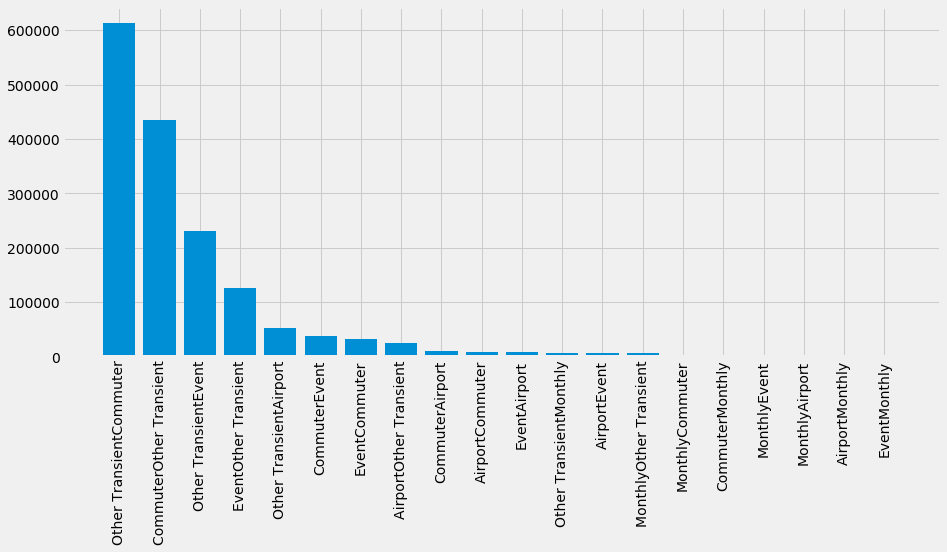

In [100]:
plt.figure(figsize=(14, 6))
plt.bar('top_two','renter_count', data=df_aggs)
plt.xticks(rotation = 90)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

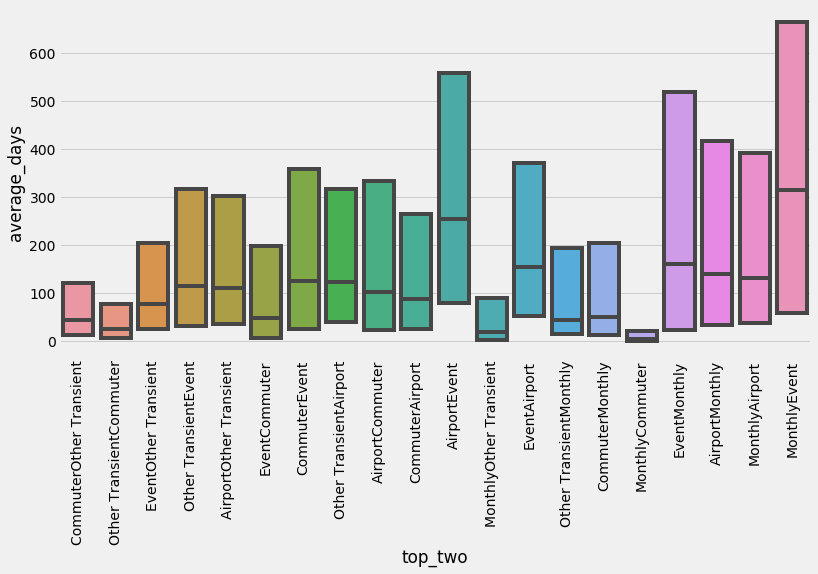

In [91]:
import seaborn as sns
x_order = df_aggs['top_two'].tolist()
plt.figure(figsize=(12, 6))
sns.boxplot('top_two','average_days', data=df, whis=0, showfliers = False, order= x_order)
plt.xticks(rotation = 90)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

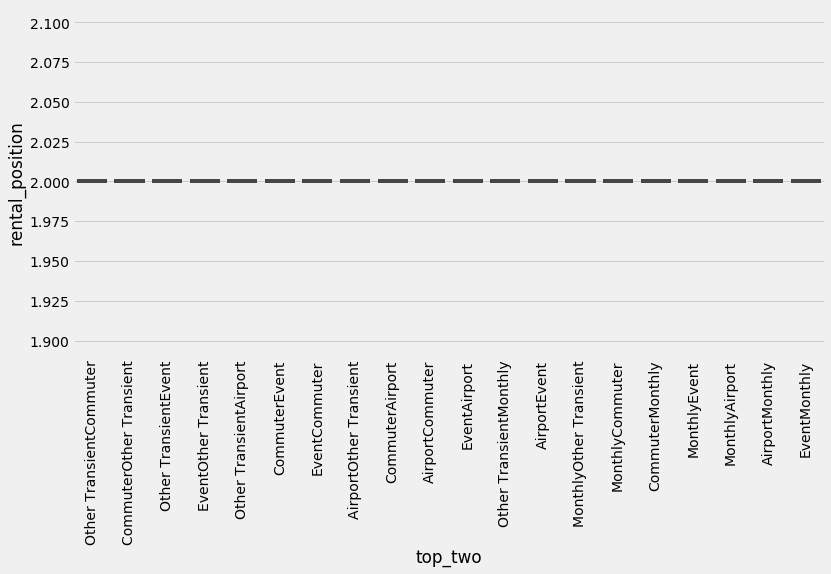

In [138]:
x_order = df_aggs.index.tolist()
plt.figure(figsize=(12, 6))
sns.boxplot('top_two','rental_position', data=df, whis=0, showfliers = False, order= x_order)
plt.xticks(rotation = 90)
plt.show

In [101]:
#Identify and remove outliers by top_two groups
def is_outlier(x): 

    IQR = np.percentile(x, 75) - np.percentile(x, 25)
    upper_fence = np.percentile(x, 75) + (IQR * 1.5)
    lower_fence = np.percentile(x, 25) - (IQR * 1.5)

    return (x > upper_fence) | (x < lower_fence)
df['outlier'] = df.groupby('top_two')['average_days'].apply(is_outlier)
filter = df.groupby('top_two')['average_days'].apply(is_outlier)

# filter = (df.groupby('top_two')['average_days'] >= Q1 - 1.5 * IQR) & (df.groupby('top_two')['average_days'] <= Q3 + 1.5 *IQR)
df_new= df[df['outlier'] == False]
print(df_new.head())

   renter_id                  top_two  average_days  rental_position  outlier
0          1  Other TransientCommuter         27.00                2    False
1          2     EventOther Transient          0.50                2    False
2          8  Other TransientCommuter          3.10                2    False
4         16     EventOther Transient          3.10               22    False
5         19     EventOther Transient         16.30               21    False


In [102]:
df_new.describe()

,renter_id,average_days,rental_position
count,1443019.00,1443019.00,1443019.00
mean,3449176.01,108.01,2.28
std,2396520.46,147.51,0.81
min,1.00,0.00,2.00
25%,1396122.00,12.00,2.00
50%,3046644.00,48.70,2.00
75%,5236959.00,145.00,2.00
max,9040779.00,1590.00,51.00


In [103]:
df_aggs2 = df_new.groupby('top_two').agg({'renter_id':[np.count_nonzero],'average_days': [np.mean],'rental_position':np.mean})
# df_aggs2.columns = df_aggs.columns.map('_'.join)
df_aggs2['median'] = df_new.groupby('top_two')['average_days'].median()
df_aggs2.columns = ['renter_count', 'average_days', 'rental_position','median_days']
df_aggs2 = df_aggs2[['renter_count', 'average_days', 'median_days', 'rental_position']]
df_aggs2 = df_aggs2.reset_index().sort_values(by='renter_count',ascending=False)
print(df_aggs2)

                    top_two  renter_count  average_days  median_days  \
17  Other TransientCommuter        549140         83.65        44.00   
7   CommuterOther Transient        381442         55.76        25.50   
18     Other TransientEvent        210814        138.91        78.00   
11     EventOther Transient        116829        202.40       115.00   
16   Other TransientAirport         47753        200.65       110.00   
5             CommuterEvent         34455        132.10        48.00   
9             EventCommuter         29397        226.58       124.00   
3    AirportOther Transient         23691        212.20       122.00   
4           CommuterAirport          9620        215.12       102.00   
0           AirportCommuter          8242        177.89        89.00   
8              EventAirport          7460        359.66       254.00   
1              AirportEvent          6544        251.06       155.00   
19   Other TransientMonthly          6165         69.40        1

In [104]:
df_aggs2['renter_percent'] = df_aggs2['renter_count'] / df_aggs2['renter_count'].sum()
print(df_aggs2)

                    top_two  renter_count  average_days  median_days  \
17  Other TransientCommuter        549140         83.65        44.00   
7   CommuterOther Transient        381442         55.76        25.50   
18     Other TransientEvent        210814        138.91        78.00   
11     EventOther Transient        116829        202.40       115.00   
16   Other TransientAirport         47753        200.65       110.00   
5             CommuterEvent         34455        132.10        48.00   
9             EventCommuter         29397        226.58       124.00   
3    AirportOther Transient         23691        212.20       122.00   
4           CommuterAirport          9620        215.12       102.00   
0           AirportCommuter          8242        177.89        89.00   
8              EventAirport          7460        359.66       254.00   
1              AirportEvent          6544        251.06       155.00   
19   Other TransientMonthly          6165         69.40        1

In [139]:
df_aggs2_abbrev = df_aggs2[['top_two','renter_count','median_days','rental_position']]
print(df_aggs2_abbrev)

                    top_two  renter_count  median_days  rental_position
17  Other TransientCommuter        549140        44.00             2.29
7   CommuterOther Transient        381442        25.50             2.35
18     Other TransientEvent        210814        78.00             2.26
11     EventOther Transient        116829       115.00             2.12
16   Other TransientAirport         47753       110.00             2.31
5             CommuterEvent         34455        48.00             2.34
9             EventCommuter         29397       124.00             2.12
3    AirportOther Transient         23691       122.00             2.23
4           CommuterAirport          9620       102.00             2.36
0           AirportCommuter          8242        89.00             2.20
8              EventAirport          7460       254.00             2.08
1              AirportEvent          6544       155.00             2.13
19   Other TransientMonthly          6165        18.00          

In [112]:
#Only core event users
event_df = df_new[df_new['top_two'].str.startswith('Event')]
event_df['top_two'].value_counts()

EventOther Transient    116829
EventCommuter            29397
EventAirport              7460
EventMonthly               231
Name: top_two, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

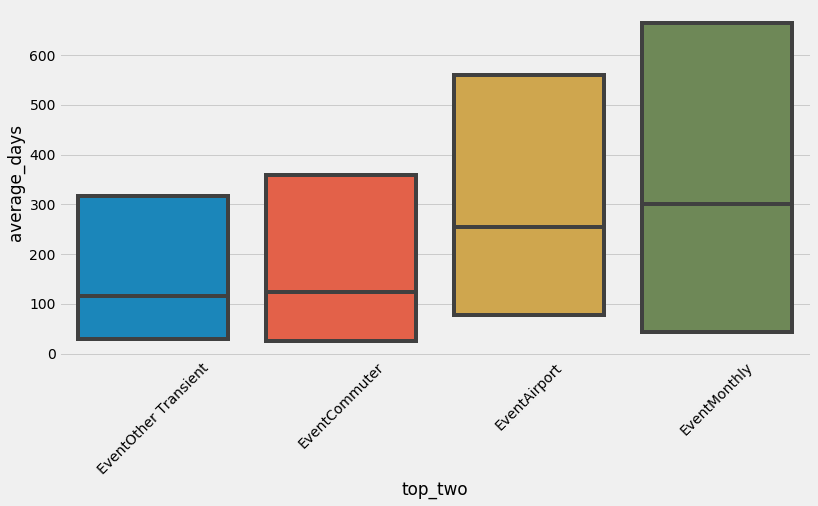

In [122]:

plt.figure(figsize=(12, 6))
sns.boxplot('top_two','average_days', data=event_df, whis=0, showfliers = False, order= ['EventOther Transient','EventCommuter', 'EventAirport', 'EventMonthly'])
plt.xticks(rotation = 45)
plt.show

In [140]:
event_df_agg = df_aggs2[df_aggs2['top_two'].str.startswith('Event')]
print(event_df_agg)

                 top_two  renter_count  average_days  median_days  \
11  EventOther Transient        116829        202.40       115.00   
9          EventCommuter         29397        226.58       124.00   
8           EventAirport          7460        359.66       254.00   
10          EventMonthly           231        416.50       301.00   

    rental_position  renter_percent  
11             2.12            0.08  
9              2.12            0.02  
8              2.08            0.01  
10             2.10            0.00  
